https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
https://rosenfelder.ai/multi-input-neural-network-pytorch/
https://www.kaggle.com/code/vgarshin/osic-keras-images-and-tabular-data-model/notebook

In [ ]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate

import matplotlib.pyplot as plt
import seaborn as sns

import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check GPU (select GPU L4 in collab)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


##Pre-treatment tabular data

In [ ]:
# Load data from geopackage (we will match the ids with image names)
gpkg_path = '/content/drive/MyDrive/Colab Notebooks/batrem/batrem_4k.gpkg'
layer_name = 'buildings'
gdf = gpd.read_file(gpkg_path, layer=layer_name)

In [ ]:
# Keep only useful columns
columns = ['id','nature', 'usage1', 'usage2','nb_logts', 'nb_etages','hauteur',
           'superficie','perimetre','indicateur_forme','granularite','convexite',
           'bat_moy_s_500','bat_moy_s_125','bat_moy_s_250','bat_moy_h_500',
           'bat_moy_h_250', 'bat_moy_h_125','remarquable', 'fold']
data_tab = gdf[columns] # tabular data

In [ ]:
# Set the building ids aside for later use
ids = data_tab['id']
data_tab = data_tab.drop(columns=['id'])

In [ ]:
# Fill empty data with aberrant value (it helps random forest training)
data_tab = data_tab.fillna(9999)

In [ ]:
# Encoding label variables
categorical_columns = ['nature', 'usage1', 'usage2']
data_tab[categorical_columns] = data_tab[categorical_columns].astype(str)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
data_encoded = encoder.fit_transform(data_tab[categorical_columns])
data_encoded = pd.DataFrame(data_encoded, columns=encoder.get_feature_names_out(categorical_columns))
data_tab = pd.concat([data_tab.drop(categorical_columns, axis=1), data_encoded], axis=1)

In [ ]:
# Separate features and target and transform in numpy array for futur operations
X = data_tab.drop('remarquable', axis=1)
y = data_tab['remarquable']
X = X.to_numpy()
y = y.to_numpy()

In [ ]:
# Scale the features (important for MLP)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
tab_shape = (X_scaled.shape[1],)

### Prepare folds for later cross validation

In [ ]:
# Define PredefinedSplit using the fold column (for specific spatial cross validation)
predefined_split = PredefinedSplit(data_tab['fold'])

In [ ]:
# Check fold balance so we can take their size into account when evaluating data. Fold numbers correspond to spatial areas
for fold_idx, (train_idx, test_idx) in enumerate(predefined_split.split()):
    print(f"Fold {fold_idx + 1}:")
    print(f"Train set: {len(train_idx)} buildings and {np.sum(y[train_idx])} are remarkable")
    print(f"Test set: {len(test_idx)} buildings and {np.sum(y[test_idx])} are remarkable")
    print()

Fold 1: 385 buildings and 98 are remarkable
Fold 2: 1181 buildings and 282 are remarkable
Fold 3: 476 buildings and 75 are remarkable
Fold 4: 619 buildings and 189 are remarkable
Fold 5: 1345 buildings and 377 are remarkable
Fold 6: 510 buildings and 108 are remarkable


##Pre-treatment images

In [ ]:
# Load images and match with tabular data
image_folder = '/content/drive/MyDrive/Colab Notebooks/batrem/image_datasets/4k/'

# Create a DataFrame mapping image filenames to labels
gdf["filename"] = gdf["id"].apply(lambda x: f"{image_folder}{x}.png")

# Image parameters
img_size = (256, 256)  # Resize images to this size

## Multimodal generator

In [ ]:
# Function to create an image generator (a tensorflow dataset actually) from specific fold indices
# Each element of the dataset will be a tuple containing an image filename and its label

def create_multimodal_generator(df, indices, batch_size=128, shuffle=False): # no shuffle because we want to match indices
    # Create a tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        df.iloc[indices]['filename'].values,
        X_scaled[indices],  # Tabular data (X_scaled)
        df.iloc[indices]['remarquable'].values # Labels
        ))

    # Preprocessing
    def preprocess_data(image_path, tabular_data, label):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, (256, 256))
        image = tf.cast(image, tf.float32) / 255.0
        # Reshape label to 2D (needed to monitor F1 score)
        label = tf.expand_dims(label, axis=-1)  # Add an extra dimension
        return (image, tabular_data), label # Return tuple for multimodal input

    dataset = dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# Build models

### MLP branch

In [ ]:
def build_mlp(tabular_shape):
    inputs = tf.keras.layers.Input(shape=tabular_shape, name="tabular_input")
    x = tf.keras.layers.Dense(32, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(0.3)(x) # reduce overfitting and improve generalisation
    mlp_features = tf.keras.layers.Dense(16, activation='relu', name="mlp_features")(x)
    model = tf.keras.Model(inputs=inputs, outputs=mlp_features, name="MLP_Model")
    return model


### CNN branch

In [ ]:
def build_cnn(input_shape=(256, 256, 3)):  # Adjust based on your image size
    # Input layer for images
    inputs = Input(shape=input_shape, name="image_input")

    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten to 1D vector
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer
    cnn_features = Dense(64, activation='relu', name="cnn_features")(x)

    # Define model
    model = Model(inputs=inputs, outputs=cnn_features, name="CNN_Model")

    return model

### Multimodal

In [ ]:
def build_multimodal_model(tabular_shape=(10,), image_shape=(256, 256, 3)):
    cnn_model = build_cnn(image_shape)
    mlp_model = build_mlp(tabular_shape)

    # Merge extracted features
    merged_features = Concatenate()([cnn_model.output, mlp_model.output])

    # Apply multiple dense layers for deeper feature fusion
    x = Dense(128, activation='relu')(merged_features)
    x = Dropout(0.3)(x)  # Regularization
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)

    # Final classification layer
    final_output = Dense(1, activation='sigmoid', name="final_output")(x)

    # Define and compile model
    model = Model(inputs=[cnn_model.input, mlp_model.input], outputs=final_output, name="Multimodal_Model")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall', 'AUC', tf.keras.metrics.F1Score(threshold=0.5, name='f1_score')])

    return model

In [ ]:
# Build multimodal model
multimodal_model = build_multimodal_model()
multimodal_model.summary()

Model: "Multimodal_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            896 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 128)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 131072)         │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tabular_input             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │     16,777,344 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │            352 │ tabular_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ dense_1[0][0]          │
├──────────────────────

 Total params: 16,901,361 (64.47 MB)

 Trainable params: 16,900,913 (64.47 MB)

 Non-trainable params: 448 (1.75 KB)

# Metric storage

In [ ]:
# Store scoring metrics for each fold
scoring = {'acc_train':[], 'acc_test':[],
           'pre_train':[], 'pre_test':[],
           'rec_train':[], 'rec_test':[],
           'f1_train':[], 'f1_test':[],
           'avg_pre_test':[],
           'roc_auc_test':[]
           }

In [ ]:
# Store interpolated curve values for each fold to later plot ROC and PR curves
interp = np.linspace(0, 1, 100) # x-coordinates at which to evaluate the interpolated values
interp_rocs = []
interp_prs = []

In [ ]:
# Store interpolated curve values for each fold to later plot ROC and PR curves
interp = np.linspace(0, 1, 100) # x-coordinates at which to evaluate the interpolated values
interp_rocs = []
interp_prs = []

In [ ]:
# Store true labels and predictions across folds to later produce confusion matrix
y_true_combined = []
y_pred_combined = []

In [ ]:
fold_histories = []

# Perform cross-validation

In [ ]:
# Perform cross-validation
start_time = time.time()

for fold_idx, (train_idx, test_idx) in enumerate(predefined_split.split()):
    print(f"Fold {fold_idx + 1}")

     # Create Train & Test Generators (tf datasets) for model fiting
    train_generator = create_multimodal_generator(gdf, train_idx)
    test_generator = create_multimodal_generator(gdf, test_idx)

    # Create model
    model = build_multimodal_model(tabular_shape=tab_shape)

    # Define callbacks
    #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=120, restore_best_weights=True)
    lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                      factor=0.7,
                                                      patience=10)

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=150,
        callbacks=[lr_schedule],
        verbose=1
    )

    fold_histories.append(history)

    # Save model
    model.save('/content/drive/MyDrive/Colab Notebooks/batrem/trained_models/multimodal/'+ f'model_multimodal_fold_{fold_idx + 1}.keras')

    # Predict on test set
    y_test_proba = model.predict(test_generator).ravel()  # Predicted probabilities to be in the positive class (remarkable)
    y_test_pred = (y_test_proba > 0.5).astype(int)  # Binary predictions

    # Filter labels for evaluation
    y_train, y_test = y[train_idx], y[test_idx]

    # Calculate metrics for this fold on test set and append to lists
    scoring['acc_test'].append(accuracy_score(y_test, y_test_pred))
    scoring['pre_test'].append(precision_score(y_test, y_test_pred))
    scoring['rec_test'].append(recall_score(y_test, y_test_pred))
    scoring['f1_test'].append(f1_score(y_test, y_test_pred))
    scoring['avg_pre_test'].append(average_precision_score(y_test, y_test_pred))

    # Predict on train set
    y_train_proba = model.predict(train_generator).ravel()  # Predicted probabilities to be in the positive class (remarkable)
    y_train_pred = (y_train_proba > 0.5).astype(int)  # Binary predictions

    # Calculate metrics for this fold on train set and append to lists
    scoring['acc_train'].append(accuracy_score(y_train, y_train_pred))
    scoring['pre_train'].append(precision_score(y_train, y_train_pred))
    scoring['rec_train'].append(recall_score(y_train, y_train_pred))
    scoring['f1_train'].append(f1_score(y_train, y_train_pred))

    # Store predictions and true labels to produce confusion matrix
    y_true_combined.extend(y_test)  # Append true labels
    y_pred_combined.extend(y_test_pred)  # Append predicted labels

    ## Compute ROC curve
    scoring['roc_auc_test'].append(roc_auc_score(y_test, y_test_proba)) # store ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_test_proba) # Compute FPR / TPR
    # Interpolate the roc curve (tpr/fpr) to have consistent number of points across folds for later ROC plotting
    interp_roc = np.interp(interp, fpr, tpr)
    interp_rocs.append(interp_roc)

    ## Compute PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    interp_pr = np.interp(interp, recall[::-1], precision[::-1])  # Reverse to ensure monotonic recall
    interp_prs.append(interp_pr)


end_time = time.time()
training_time = end_time - start_time
print(f"Temps d'entraînement : {training_time / 60:.2f} minutes")

Fold 1
Epoch 1/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step - AUC: 0.4803 - Precision: 0.6305 - Recall: 0.9904 - binary_accuracy: 0.7045 - f1_score: 0.7472 - loss: 59.2809 - val_AUC: 0.4107 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_binary_accuracy: 0.7455 - val_f1_score: 0.0000e+00 - val_loss: 0.9540 - learning_rate: 0.0010
Epoch 2/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - AUC: 0.1209 - Precision: 0.3495 - Recall: 0.0697 - binary_accuracy: 0.3220 - f1_score: 0.0930 - loss: 7.9625 - val_AUC: 0.4071 - val_Precision: 0.2545 - val_Recall: 1.0000 - val_binary_accuracy: 0.2545 - val_f1_score: 0.4058 - val_loss: 2.7469 - learning_rate: 0.0010
Epoch 3/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - AUC: 0.1957 - Precision: 0.4706 - Recall: 0.1833 - binary_accuracy: 0.3708 - f1_score: 0.2307 - loss: 2.1932 - val_AUC: 0.2976 - val_Precision: 0.1911 - val_Recall: 0.4388 - val_binary_accuracy: 0.3844 - val_f1_score: 0.2663 - val_loss: 1.3857 - learning_rate: 0.0010
Epoch 4/150


# Evaluation

In [ ]:
# for each metric, print the score of the six folds on test set
for metric in scoring.keys():
    print(f"Fold scores for {metric}: {scoring[metric]}")

Fold scores for acc_train: [0.906076010651174, 0.9220389805097451, 0.9027227722772277, 0.9317423659225045, 0.9176915799432356, 0.9028956565152272]
Fold scores for acc_test: [0.8701298701298701, 0.8018628281117697, 0.8361344537815126, 0.7318255250403877, 0.7710037174721189, 0.8117647058823529]
Fold scores for pre_train: [0.8935128518971848, 0.9916247906197655, 0.9199491740787802, 0.9841954022988506, 0.9823182711198428, 0.9540229885057471]
Fold scores for pre_test: [0.8157894736842105, 0.7727272727272727, 0.45161290322580644, 0.6493506493506493, 0.8165137614678899, 0.6]
Fold scores for rec_train: [0.7080504364694471, 0.6989374262101535, 0.6869070208728653, 0.7287234042553191, 0.6648936170212766, 0.6503428011753183]
Fold scores for rec_test: [0.6326530612244898, 0.24113475177304963, 0.18666666666666668, 0.26455026455026454, 0.23607427055702918, 0.3333333333333333]
Fold scores for f1_train: [0.79004329004329, 0.8199445983379502, 0.7865290602933188, 0.8374083129584352, 0.7930214115781126, 0

In [ ]:
# Print the mean of each
for metric in scoring.keys():
    print(f"Mean {metric}: {np.average(scoring[metric])}")

Mean acc_train: 0.9138612276365189
Mean acc_test: 0.8037868500696687
Mean pre_train: 0.9542705797533616
Mean pre_test: 0.6843323434093048
Mean rec_train: 0.6896424510007299
Mean rec_test: 0.3157353913508055
Mean f1_train: 0.8000647872164115
Mean f1_test: 0.4191881018921873
Mean avg_pre_test: 0.3890011139161289
Mean roc_auc_test: 0.7398446948413868


In [ ]:
# Print history keys to verify that each metric as been monitored
print(history.history.keys())

dict_keys(['AUC', 'Precision', 'Recall', 'binary_accuracy', 'f1_score', 'loss', 'val_AUC', 'val_Precision', 'val_Recall', 'val_binary_accuracy', 'val_f1_score', 'val_loss', 'learning_rate'])


In [ ]:
# Create function to plot metrics for each fold during training
def plot_metric(metric, y_max=1):
    plt.figure(figsize=(10, 6))
    plt.ylim(0, y_max)

    max_epochs = max(len(history.history[metric]) for history in fold_histories)  # Get the maximum number of epochs

    for fold_idx, value in enumerate(fold_histories):
        # Pad shorter arrays with NaN to match the longest array
        padded_values = np.pad(value.history[metric], (0, max_epochs - len(value.history[metric])), 'constant', constant_values=np.nan)
        plt.plot(padded_values, alpha=0.4, label=f'Fold {fold_idx + 1}')

    # plot the mean curve (ignoring NaN values)
    all_values = [np.pad(history.history[metric], (0, max_epochs - len(history.history[metric])), 'constant', constant_values=np.nan) for history in fold_histories]
    mean_curve = np.nanmean(all_values, axis=0)  # Use np.nanmean to ignore NaNs
    plt.plot(mean_curve, color='blue', label=f'Mean {metric}', lw=2)

    plt.title(f'{metric.capitalize()} Across Epochs for Each Fold', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel(metric.capitalize(), fontsize=14)
    plt.legend(title='Folds', fontsize=12)
    plt.grid(True)
    plt.show()

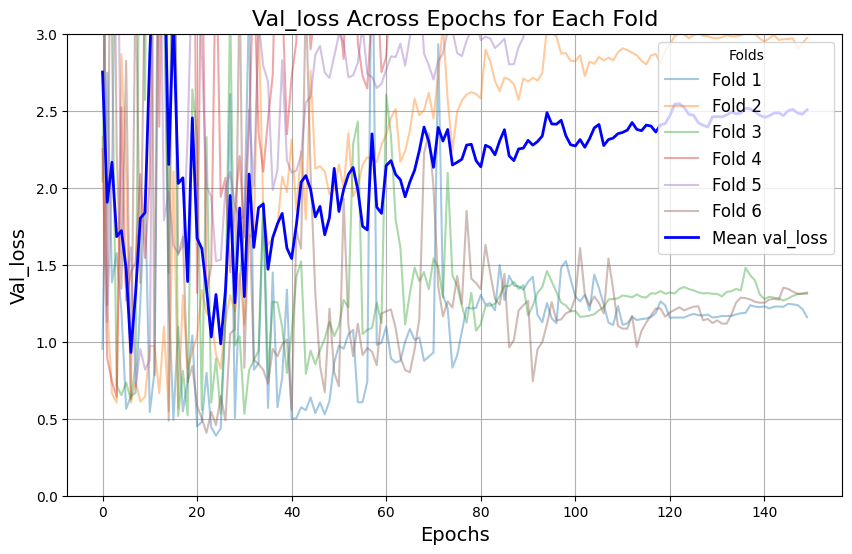

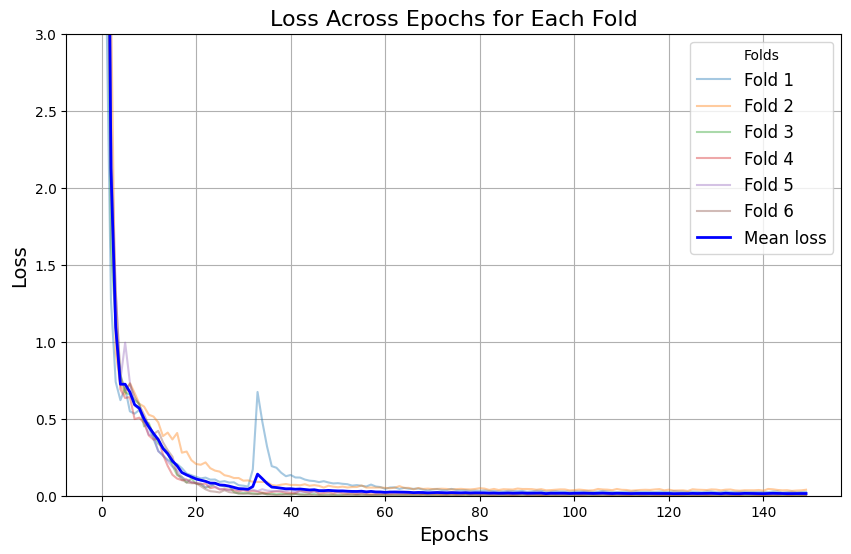

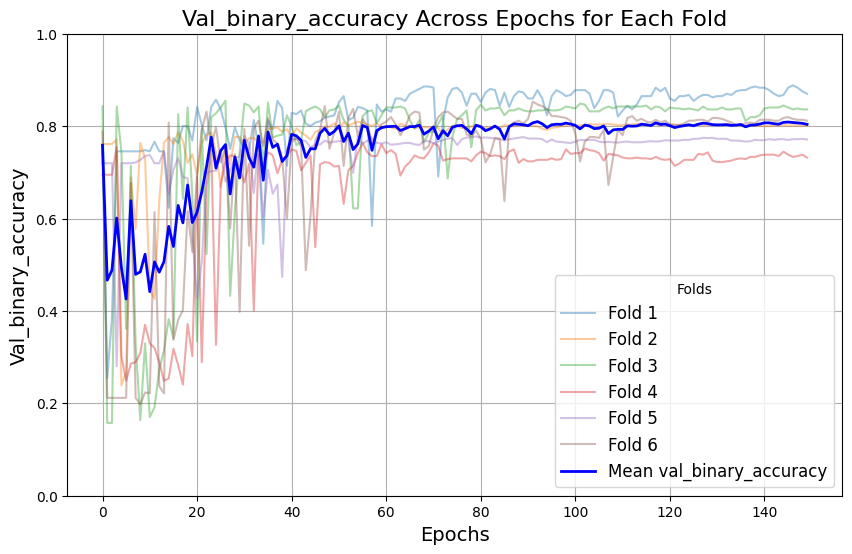

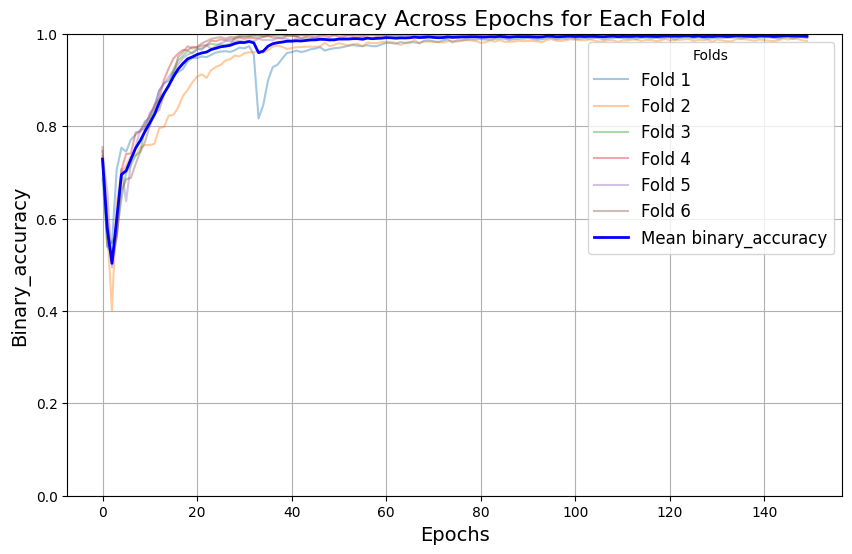

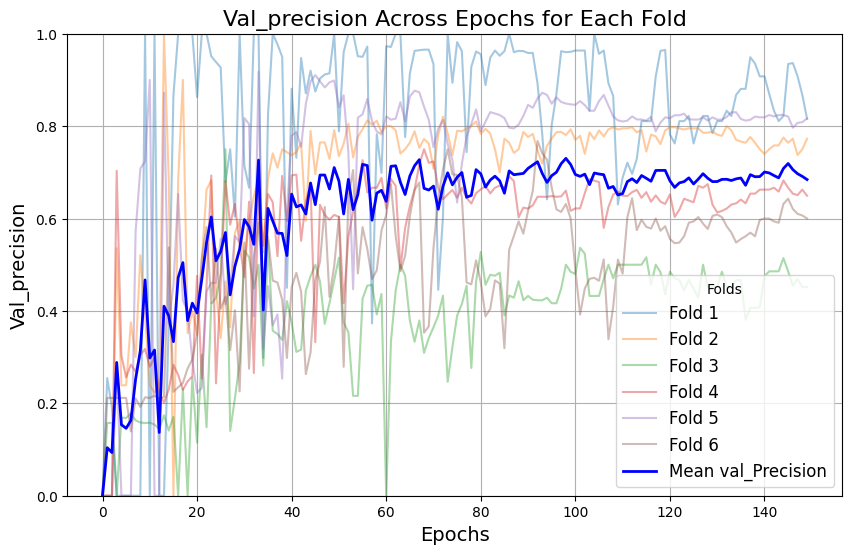

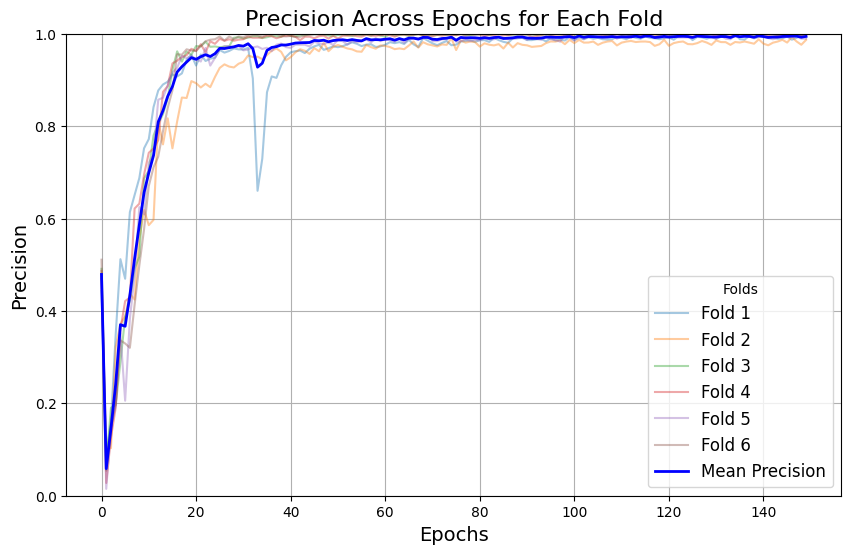

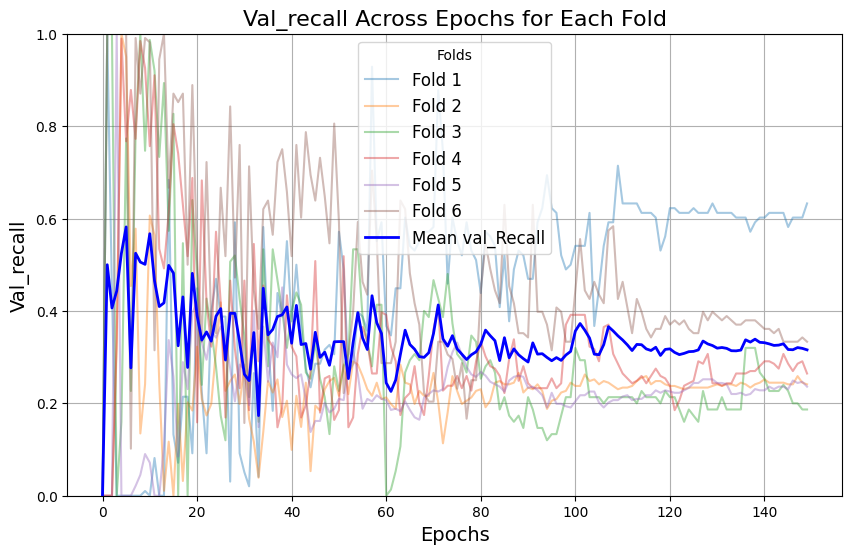

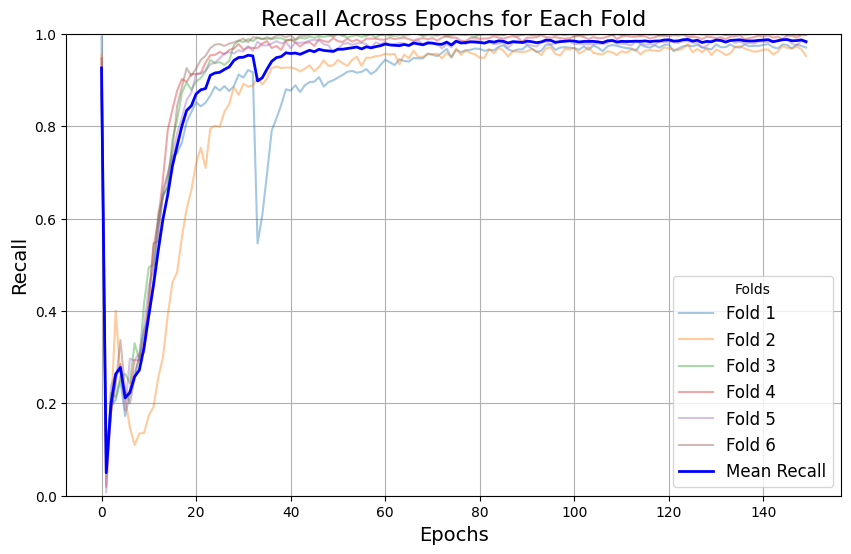

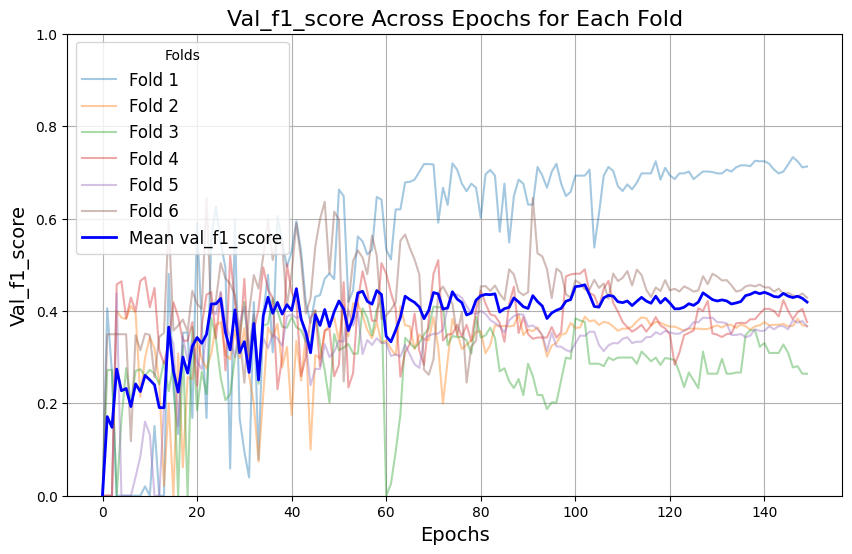

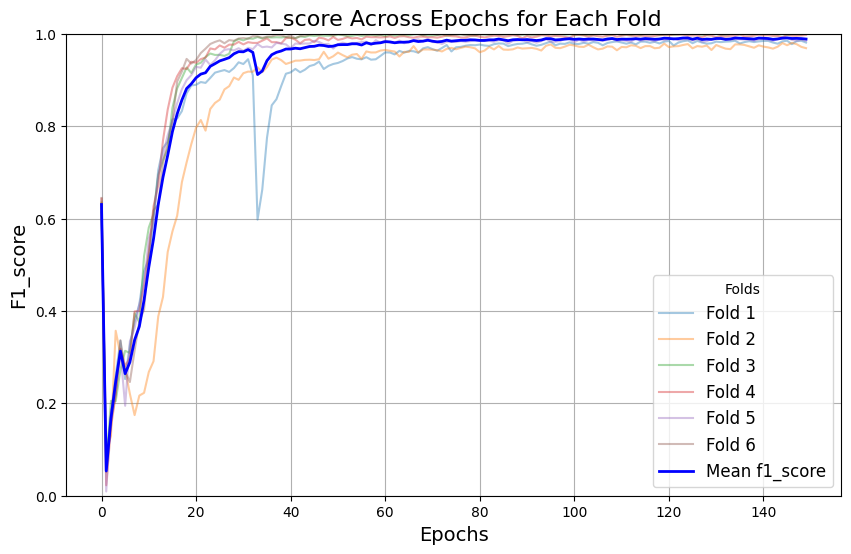

In [ ]:
# plot val loss, train loss, val accuracy, train accuracy, val precision, train precision
plot_metric('val_loss', y_max=3)
plot_metric('loss', y_max=3)
plot_metric('val_binary_accuracy')
plot_metric('binary_accuracy')
plot_metric('val_Precision')
plot_metric('Precision')
plot_metric('val_Recall')
plot_metric('Recall')
plot_metric('val_f1_score')
plot_metric('f1_score')
plot_metric('val_auc')
plot_metric('auc')


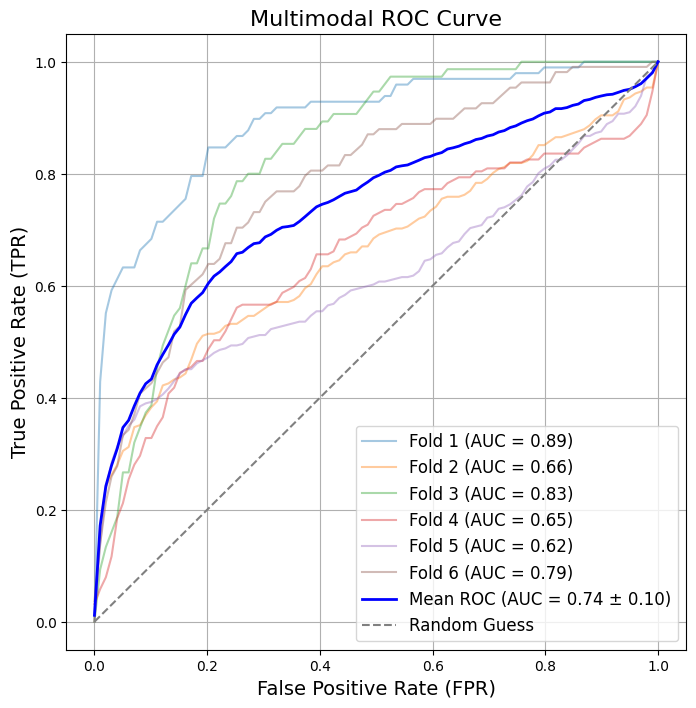

In [ ]:
### Plot ROC curve
plt.figure(figsize=(8, 8))

# Plot individual fold ROC curves
for i, (interp_roc, auc) in enumerate(zip(interp_rocs, scoring['roc_auc_test'])):
    plt.plot(interp, interp_roc, alpha=0.4, label=f'Fold {i+1} (AUC = {auc:.2f})')

# Compute and plot the mean ROC curve and its AUC
mean_roc = np.mean(interp_rocs, axis=0)
mean_roc[-1] = 1.0  # Ensure the curve ends at (1, 1)
mean_auc = np.mean(scoring['roc_auc_test'])
std_auc = np.std(scoring['roc_auc_test'])
plt.plot(np.linspace(0, 1, 100), mean_roc, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

# Finalize the plot
plt.title('Multimodal ROC Curve', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

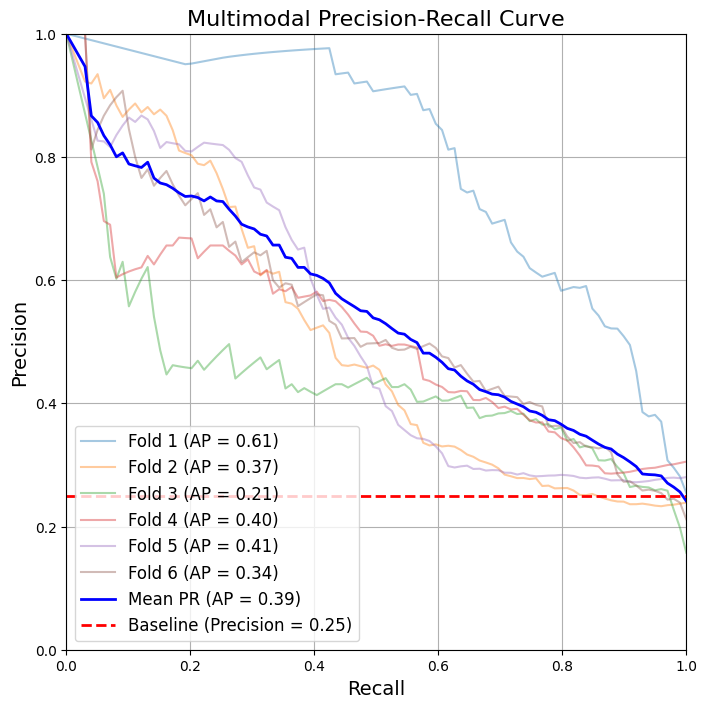

In [ ]:
### Plot the PR curve
plt.figure(figsize=(8, 8))

# Force to display x and y from 0 to 1
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# Plot individual fold PR curves
for i, interp_pr in enumerate(interp_prs):
    plt.plot(interp, interp_pr, alpha=0.4, label=f'Fold {i+1} (AP = {scoring["avg_pre_test"][i]:.2f})')

# Compute and plot the  mean PR curve
mean_pr = np.mean(interp_prs, axis=0)
mean_avg_precision = np.mean(scoring["avg_pre_test"])
plt.plot(np.linspace(0, 1, 100), mean_pr, color='blue', label=f'Mean PR (AP = {mean_avg_precision:.2f})', lw=2)

# Add the baseline
baseline_precision = 0.25
plt.axhline(y=baseline_precision, color='red', linestyle='--', label=f'Baseline (Precision = {baseline_precision:.2f})', lw=2)

# Finalize the plot
plt.title('Multimodal Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.88      3387
           1       0.72      0.28      0.41      1129

    accuracy                           0.79      4516
   macro avg       0.76      0.62      0.64      4516
weighted avg       0.78      0.79      0.76      4516



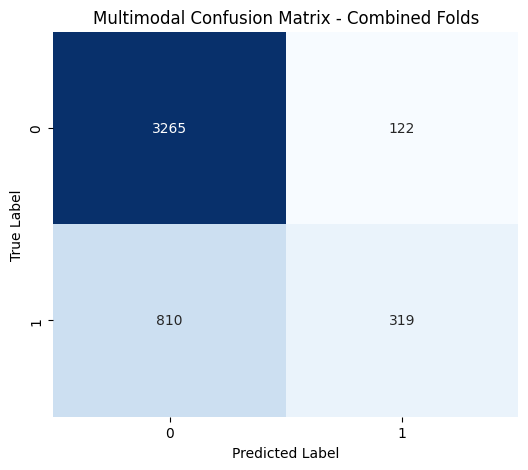

In [ ]:
## Confusion Matrix

# Convert lists to numpy arrays
y_true_combined = np.array(y_true_combined)
y_pred_combined = np.array(y_pred_combined)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_combined, y_pred_combined)

# Print classification report
print("Classification Report:\n", classification_report(y_true_combined, y_pred_combined))

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1], cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Multimodal Confusion Matrix - Combined Folds")
plt.show()

In [ ]:
## Save predictions on validation sets

# Create an empty list to store IDs for combined predictions
combined_ids = []

# Iterate through folds to get test set indices and corresponding IDs
for fold_idx, (train_idx, test_idx) in enumerate(predefined_split.split()):
    # Append IDs from the test set of this fold to combined_ids
    combined_ids.extend(ids[test_idx])

# Create the DataFrame
results_df = pd.DataFrame({'id': combined_ids, 'y_true': y_true_combined, 'y_pred': y_pred_combined})

# save as results_df as csv
path = '/content/drive/MyDrive/Colab Notebooks/batrem/multimodal_pred.csv'
results_df.to_csv(path, index=False)